In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [114]:
# carregar os dados do CSV
df = pd.read_csv("dados_3_meses.csv", sep=";")

# conversão dos dados
df['data'] = pd.to_datetime(df['data'])
df['hora'] = pd.to_datetime(df['hora'], format='%H:%M:%S')


In [108]:
# calcular a energia gerada (Wh) = irradiação * tempo (em horas) * área do painel * eficiência
tempo_horas = 0.25 # 15 minutos
area_painel = 2 # m2 - área média 

def eficiencia_energetica(status):
    if status == "Operando...":
        return 0.18
    elif status == "Falha":
        return 0.05
    else:
        return 0.0
    
energia_por_registro = df.apply(lambda x: round(x['irradiacao_solar'] * eficiencia_energetica(x['status_painel']) * tempo_horas * area_painel), axis=1) 

# Verificar o quanto de energia o painel gera por dia (Wh), com base na eficiência energética do painel solar
energia_gerada_dia = energia_por_registro.groupby(df['data']).sum()
print(energia_gerada_dia)

data
2025-02-01     961
2025-02-02    2142
2025-02-03    2389
2025-02-04    2116
2025-02-05    1978
              ... 
2025-04-26    2271
2025-04-27    2596
2025-04-28    2169
2025-04-29    2109
2025-04-30    1090
Length: 89, dtype: int64


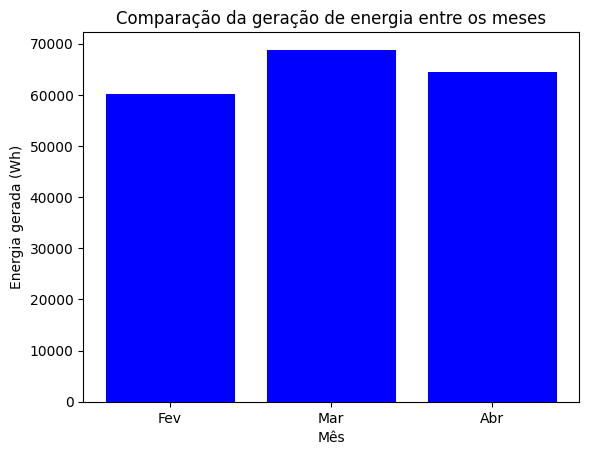

In [109]:
# Mês mais produtivo (maior energia gerada)
df_temp = pd.DataFrame({
    'mes': df['data'].dt.month,
    'energia': energia_por_registro
})
energia_por_mes = df_temp.groupby('mes')['energia'].sum()

x = energia_por_mes.index # index - meses
y = energia_por_mes.values # values - valores somados de energia para cada mês

plt.bar(x,y, color='blue')
plt.xlabel("Mês")
plt.ylabel("Energia gerada (Wh)")
plt.xticks([2, 3, 4], ['Fev', 'Mar', 'Abr'])
plt.title("Comparação da geração de energia entre os meses")
plt.show()


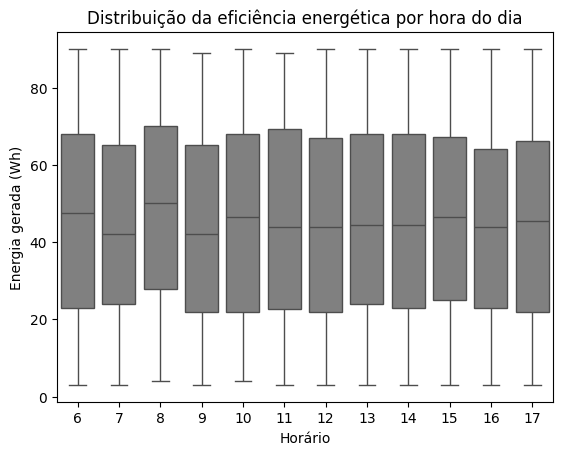

In [110]:
# Verificar a distribuição de energia por horário
df['hora'] = df['hora'].dt.hour
df = df[(df['hora'] >=6) & (df['hora'] < 18)]

# nova energia_por_registro contendo menos registros (apenas horários entre 6 e 17:59)
energia_por_registro = df.apply(lambda x: round(x['irradiacao_solar'] * eficiencia_energetica(x['status_painel']) * tempo_horas * area_painel), axis=1)
df_temp = pd.DataFrame({
    'hora': df['hora'],
    'energia': energia_por_registro
})

sns.boxplot(x='hora', y='energia', data=df_temp, color='grey')
plt.xlabel("Horário")
plt.ylabel("Energia gerada (Wh)")
plt.title("Distribuição da eficiência energética por hora do dia")
plt.show()


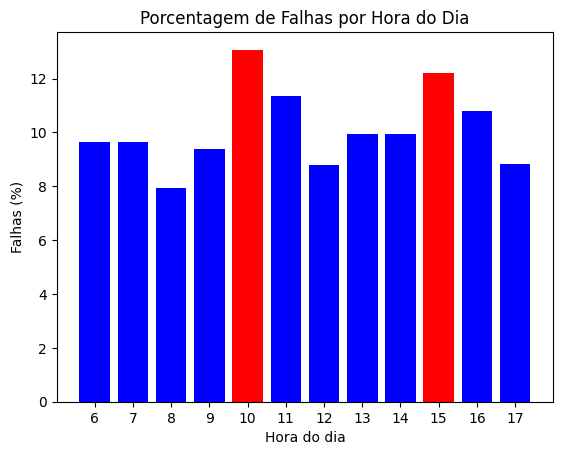

In [115]:
# Em quais horários há maior probabilidade de falhas
df['hora'] = df['hora'].dt.hour

df_falha = df[df["status_painel"] == "Falha"]
df = df[(df['hora'] >=6) & (df['hora'] < 18)]
# para cada hora, conta o total de registros
total_registros_hora = df.groupby('hora').size()
# para cada hora, conta o total de falhas
falhas_hora = df_falha.groupby('hora').size()

porcentagem_falhas_hora = round((falhas_hora/total_registros_hora) * 100, 2)
#print(porcentagem_falhas_hora)
limite = 12

cores = ['red' if value > limite else 'blue' for value in y]

x = porcentagem_falhas_hora.index
y = porcentagem_falhas_hora.values

plt.bar(x,y, color=cores)
plt.xlabel("Hora do dia")
plt.ylabel("Falhas (%)")
plt.xticks(x)
plt.title("Porcentagem de Falhas por Hora do Dia")
plt.show()


C:\Users\55219\AppData\Local\Temp\ipykernel_8148\1646936118.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_registros_tempPainel = df.groupby('intervalo_temperatura').size()
C:\Users\55219\AppData\Local\Temp\ipykernel_8148\1646936118.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  falhas_tempPainel = df_falha.groupby('intervalo_temperatura').size()


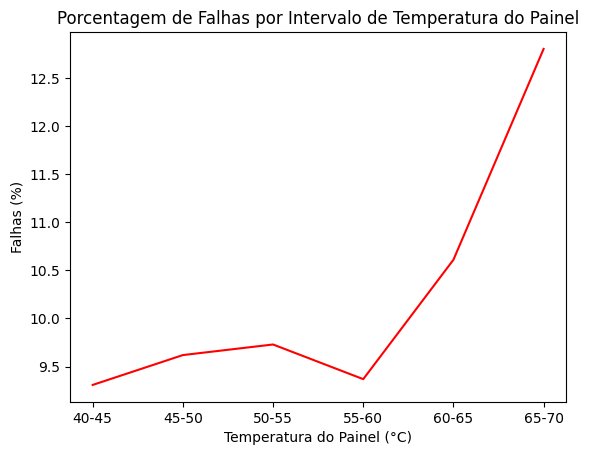

In [116]:
# Relação entre índice de falhas e temperatura do painel
df = df[(df['temp_painel'] >=40) & (df['temp_painel'] <= 70)]

bins = [40, 45, 50, 55, 60, 65, 70]
df['intervalo_temperatura'] = pd.cut(df['temp_painel'], bins=bins, labels=['40-45', '45-50', '50-55', '55-60', '60-65', '65-70'])
df_falha = df[df["status_painel"] == "Falha"]

# para cada intervalo de temperatura do painel, conta o total de registros
total_registros_tempPainel = df.groupby('intervalo_temperatura').size()
# para cada intervalo de temperatura do painel, conta o total de falhas
falhas_tempPainel = df_falha.groupby('intervalo_temperatura').size()

porcentagem_falhas_tempPainel = round((falhas_tempPainel/total_registros_tempPainel) * 100, 2)

x = porcentagem_falhas_tempPainel.index
y = porcentagem_falhas_tempPainel.values

plt.plot(x,y, color = 'red')
plt.xlabel("Temperatura do Painel (°C)")
plt.ylabel("Falhas (%)")
plt.title("Porcentagem de Falhas por Intervalo de Temperatura do Painel")
plt.show()



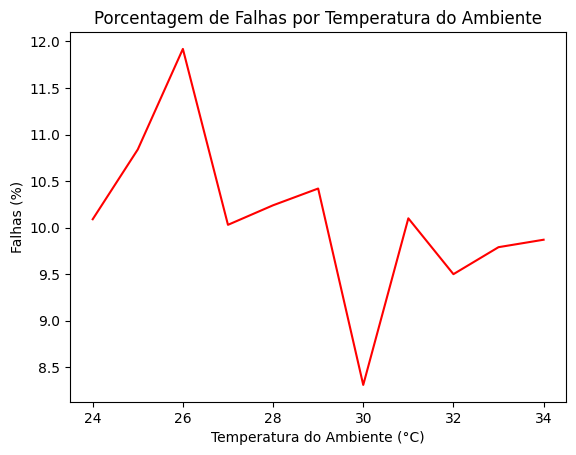

In [117]:
# Faixa de temperatura ambiental em que o painel apresenta menos falhas
df = df[(df['temp_ambiente'] >=24) & (df['temp_ambiente'] <=35)]
df_falha = df[df["status_painel"] == "Falha"]

# para cada intervalo de temperatura do ambiente, conta o total de registros
total_registros_tempAmbiente = df.groupby('temp_ambiente').size()
# para cada intervalo de temperatura do ambiente, conta o total de falhas
falhas_tempAmbiente = df_falha.groupby('temp_ambiente').size()

porcentagem_falhas_tempAmbiente = round((falhas_tempAmbiente/total_registros_tempAmbiente) * 100, 2)

x = porcentagem_falhas_tempAmbiente.index
y = porcentagem_falhas_tempAmbiente.values

plt.plot(x,y, color = 'red')
plt.xlabel("Temperatura do Ambiente (°C)")
plt.ylabel("Falhas (%)")
plt.title("Porcentagem de Falhas por Temperatura do Ambiente")
plt.show()
